In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from matplotlib import gridspec
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'axes.grid': True,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"


In [ ]:
model = Frustration3D(strengthA=1, strengthB=1, 
                      distanceD0=1.3, phaseLagAlpha0=0.8 * np.pi,
                      boundaryLength=10,
                      tqdm=True, savePath=SAVE_PATH, shotsnaps=5, dt=0.01)

In [3]:
model.run(80000)

100%|█████████████████████████████████████████████████████████| 80000/80000 [33:59<00:00, 39.22it/s]


In [ ]:
sa = StateAnalysis3D(model)
# colorIdxs = np.argsort(
#     #   sa.totalPositionX[0, :, 0] * model.agentsNum**2 
#     + sa.totalPositionX[0, :, 1] * model.agentsNum 
#     # + sa.totalPositionX[0, :, 2]
# )
colorIdxs = np.argsort(sa.totalPhaseSigma[0].mean(axis=1))

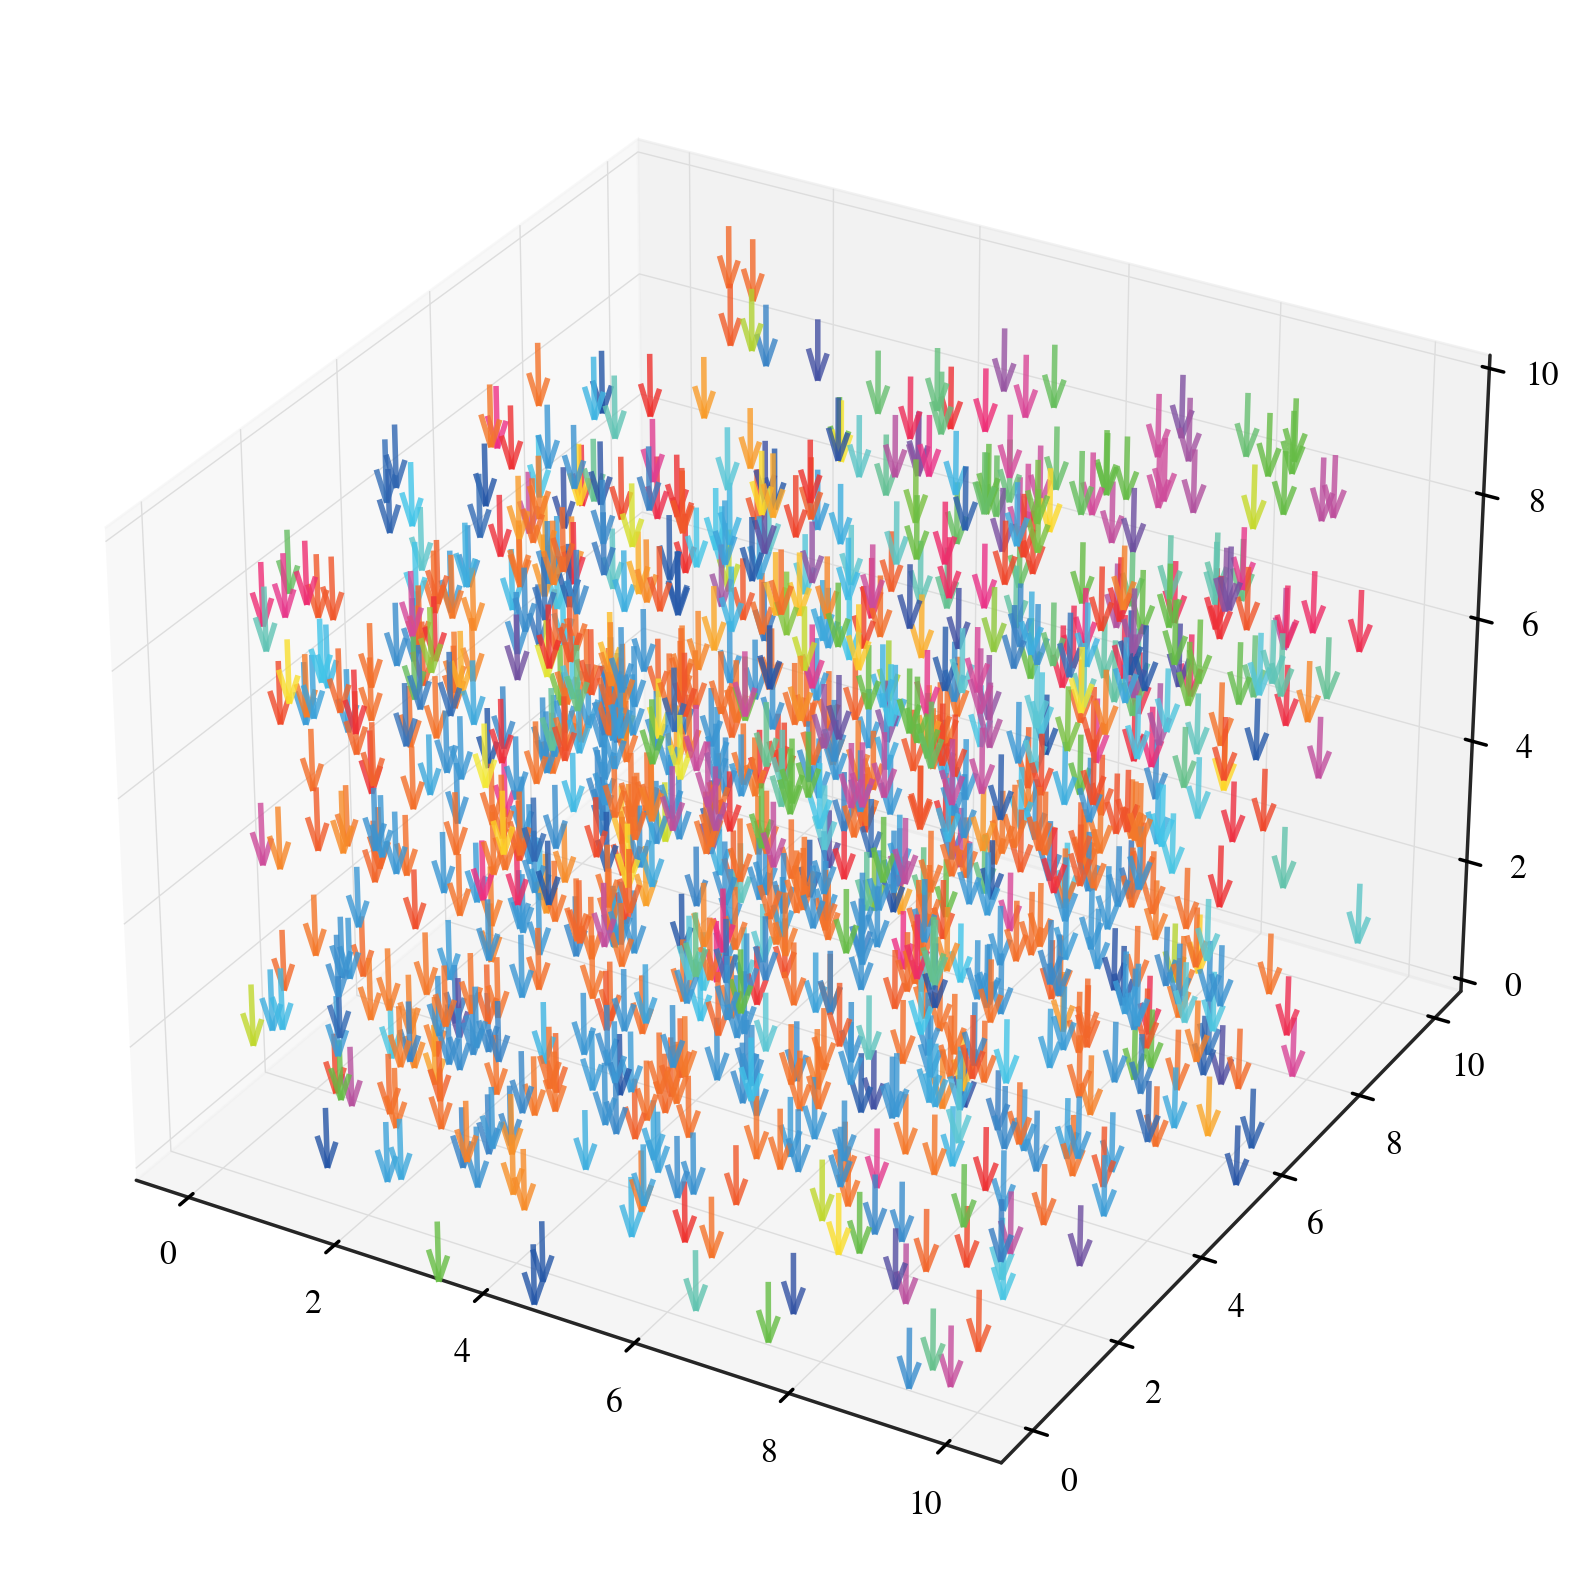

In [ ]:
from matplotlib.colors import Normalize

def vectors_to_cmap_colors(vectors):
    x, y, z = vectors.T
    phi = np.arctan2(y, x)  # 方位角 [-π, π]
    phi[phi < 0] += 2 * np.pi  # 转到 [0, 2π)
    phi_norm = phi / (2 * np.pi)  # 归一化到 [0,1]
    
    norm = Normalize(vmin=0, vmax=1)
    colors = hexCmap(norm(phi_norm))
    return colors

# positionX, phaseSigma = sa.get_state(-1)
positionX, phaseSigma = model.positionX, model.phaseSigma

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

colors = vectors_to_cmap_colors(phaseSigma)
for i in range(len(colors)):
    ax.quiver(X=positionX[i, 0], Y=positionX[i, 1], Z=positionX[i, 2],
              U=phaseSigma[i, 0], V=phaseSigma[i, 1], W=phaseSigma[i, 2],
              colors=colors[i],
              alpha=0.8, length=1, arrow_length_ratio=0.5, linewidths=2)


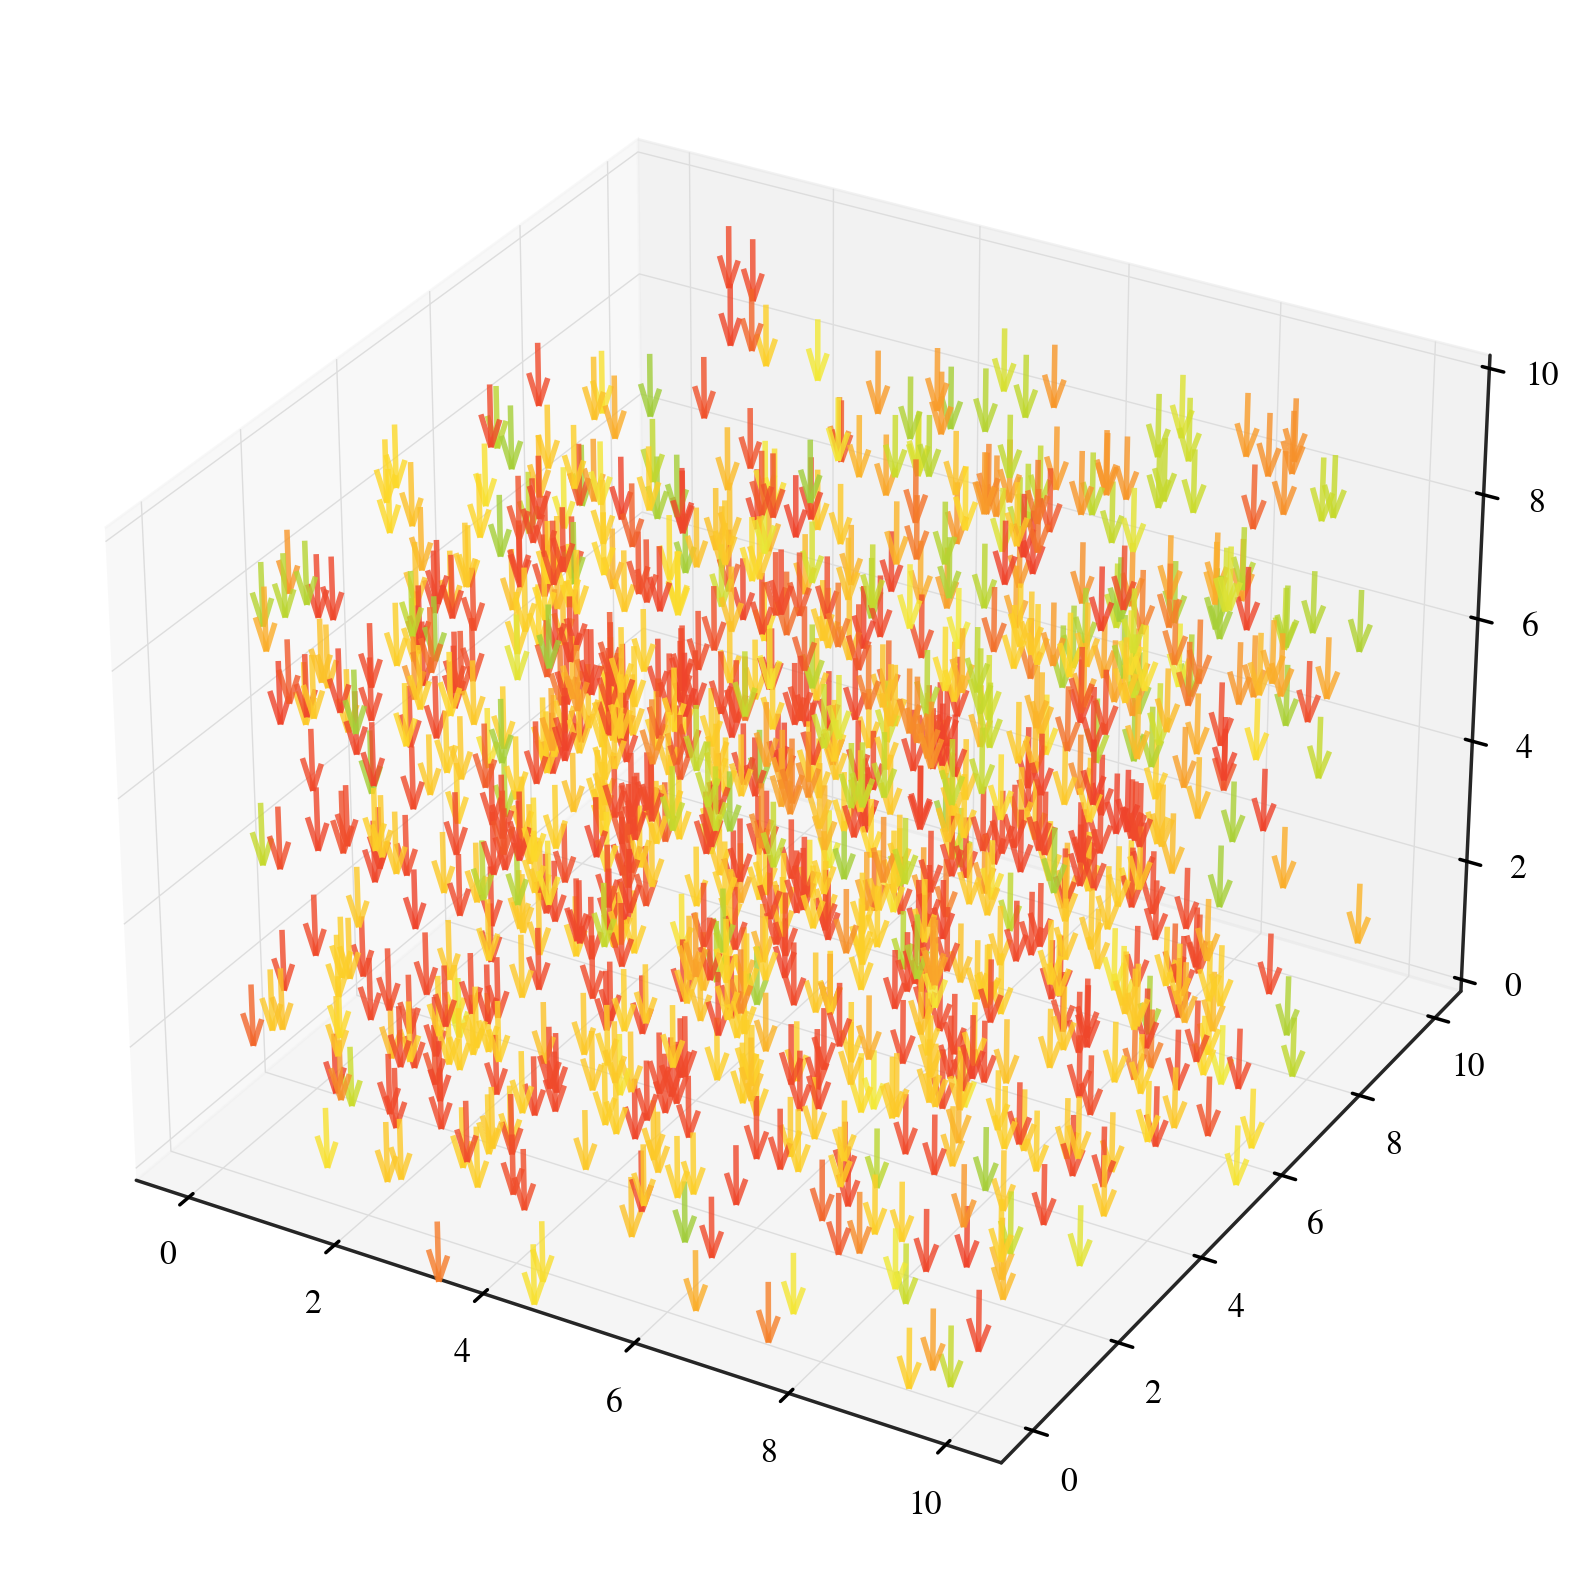

In [10]:
# def vectors_to_cmap_colors(vectors):
#     """
#     用 z 坐标（或 cosθ）映射颜色。
#     """
#     z = vectors[:, 2]  # z = cosθ
#     norm = Normalize(vmin=-1, vmax=1)  # z ∈ [-1,1]
#     colors = hexCmap(norm(z))
#     return colors

def vectors_to_cmap_colors(vectors, theta_weight=0.8):
    """
    将单位向量映射到 colormap 的颜色（结合 θ 和 φ）。
    
    参数：
        vectors: (N, 3) 数组，单位向量。
        cmap_name: matplotlib colormap 名称。
        theta_weight: θ 的权重（0 表示仅用 φ，1 表示 φ 和 θ 同等重要）。
    
    返回：
        colors: (N, 4) RGBA 数组。
    """
    x, y, z = vectors.T
    theta = np.arccos(z)  # [0, π]
    phi = np.arctan2(y, x)  # [-π, π]
    phi[phi < 0] += 2 * np.pi  # [0, 2π)
    
    # 归一化
    phi_norm = phi / (2 * np.pi)  # [0,1]
    theta_norm = theta / np.pi  # [0,1]
    
    # 结合 φ 和 θ
    scalar = (1 - theta_weight) * phi_norm + theta_weight * theta_norm
    # print(scalar)
    # 使用 colormap 映射
    norm = Normalize(vmin=0, vmax=1)
    colors = hexCmap(norm(scalar))
    return colors


positionX, phaseSigma = model.positionX, model.phaseSigma
colors = vectors_to_cmap_colors(phaseSigma)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for i in range(len(colors)):
    ax.quiver(X=positionX[i, 0], Y=positionX[i, 1], Z=positionX[i, 2],
              U=phaseSigma[i, 0], V=phaseSigma[i, 1], W=phaseSigma[i, 2],
              colors=colors[i],
              alpha=0.8, length=1, arrow_length_ratio=0.5, linewidths=2)

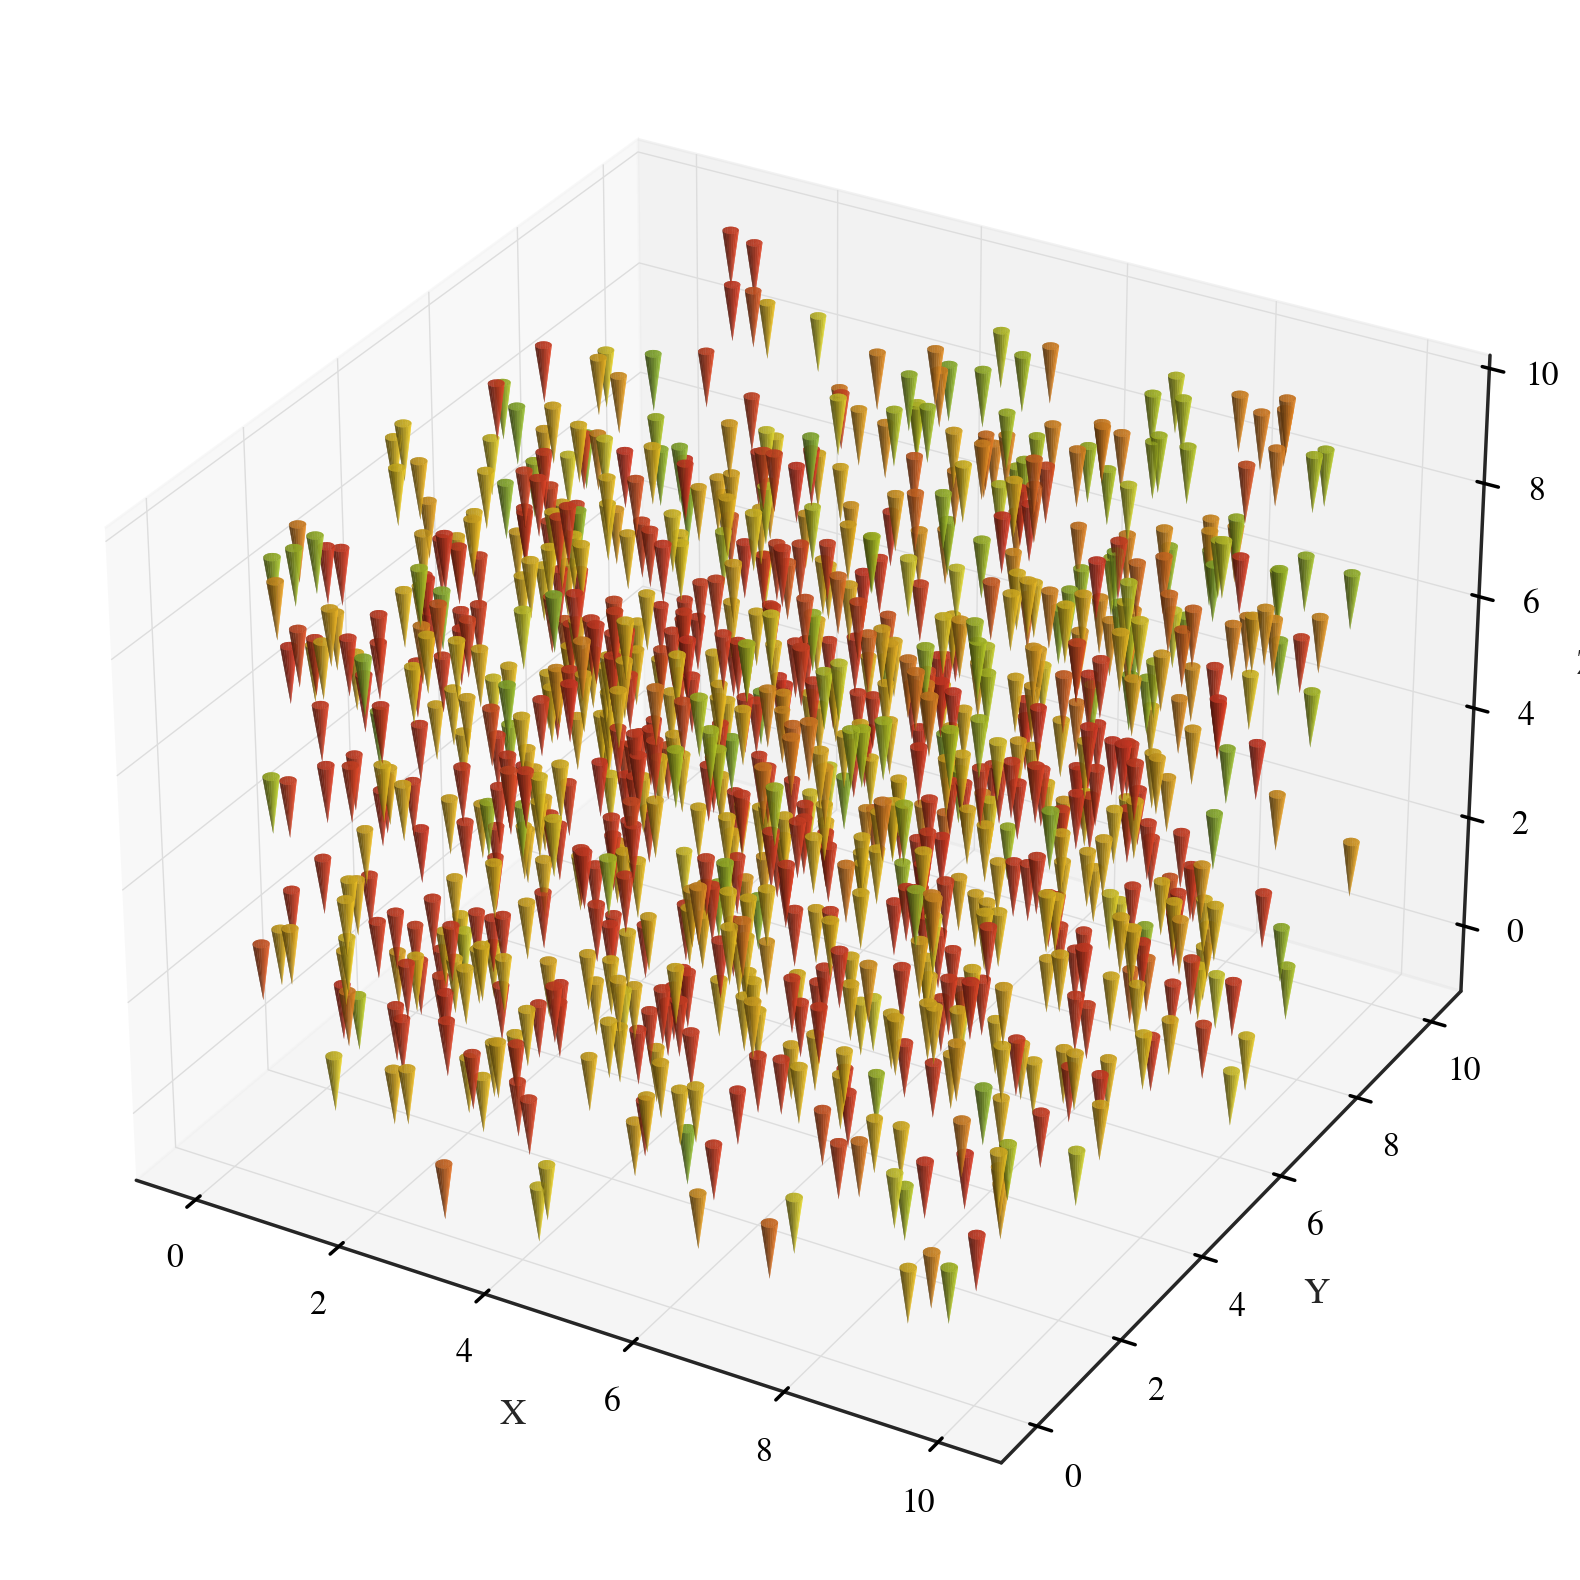

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d

def draw_cone(ax, origin, direction, color, length=1, radius=0.1):
    """绘制3D锥体"""
    direction = direction / np.linalg.norm(direction) * length  # 标准化并缩放
    
    # 锥体底部中心
    base_center = origin
    
    # 锥体顶部
    apex = origin + direction
    
    # 创建底部圆
    theta = np.linspace(0, 2*np.pi, 20, endpoint=False)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = np.zeros_like(x)
    
    # 将圆平移到正确位置
    # 需要找到垂直于方向的平面
    if np.allclose(direction, [0, 0, 1]):
        # 如果方向是Z轴，直接使用XY平面
        verts = np.column_stack([x, y, z])
    elif np.allclose(direction, [0, 0, -1]):
        # 如果方向是负Z轴，也使用XY平面但反向
        verts = np.column_stack([x, y, z])
    else:
        # 找到垂直于方向的向量
        v1 = np.array([direction[1], -direction[0], 0])
        if np.linalg.norm(v1) < 1e-6:  # 如果direction平行于Y轴
            v1 = np.array([0, direction[2], -direction[1]])
        v1 = v1 / np.linalg.norm(v1)
        v2 = np.cross(direction, v1)
        v2 = v2 / np.linalg.norm(v2)
        
        # 创建圆的顶点
        verts = np.column_stack([
            radius * (np.cos(theta)[:, None] * v1 + np.sin(theta)[:, None] * v2)
        ])
    
    verts += base_center
    
    # 创建锥体侧面
    triangles = []
    for i in range(len(verts)-1):
        triangles.append([apex, verts[i], verts[i+1]])
    triangles.append([apex, verts[-1], verts[0]])
    
    # 创建底部
    triangles.append([base_center, verts[0], verts[-1]])
    for i in range(len(verts)-1):
        triangles.append([base_center, verts[i+1], verts[i]])
    
    # 绘制所有三角形
    for tri in triangles:
        ax.plot_trisurf(
            np.array([p[0] for p in tri]),
            np.array([p[1] for p in tri]),
            np.array([p[2] for p in tri]),
            color=color, alpha=0.8, linewidth=0
        )

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for i in range(len(colors)):
    origin = positionX[i]
    direction = phaseSigma[i]
    draw_cone(ax, origin, direction, colors[i], length=1, radius=0.1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [6]:
model = Frustration3D(strengthA=1, strengthB=-0.5, 
                      distanceD0=5, phaseLagAlpha0=0.7 * np.pi,
                      boundaryLength=10, speedV=3, agentsNum=1000,
                      tqdm=True, savePath=SAVE_PATH, 
                      shotsnaps=5, dt=0.01,
                      randomSeed=10, overWrite=False)
positionX = pd.read_hdf(f"temp/SingleLastState_{model}.h5", key="positionX").values
phaseSigma = pd.read_hdf(f"temp/SingleLastState_{model}.h5", key="phaseSigma").values

In [ ]:
%matplotlib widget

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(positionX[:, 0], positionX[:, 1], positionX[:, 2])